# 07 Effects

Surge has a large (and growing) set of available effects. As of this writing, Surge contains 8 effect slots, and 15 effects. This tutorial will demonstrate the use of the Surge Python API to activate these effects, tune the effect parameters, and process audio through the Surge effects rack.

In [54]:
import os
# Replace this with a path to the built surgepy
os.chdir("../../surge/buildpy/")

import surgepy
import surgepy.constants as srco
import numpy as np
import IPython

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

surgepy.getVersion()

'1.8.chowdsp-gru.f1f8aa7f'

## Loading an Effect

Let's say we want to use a Surge patch that plays sine tones, and then use the Distortion effect to add harmonic distortion. First let's load the desired patch:

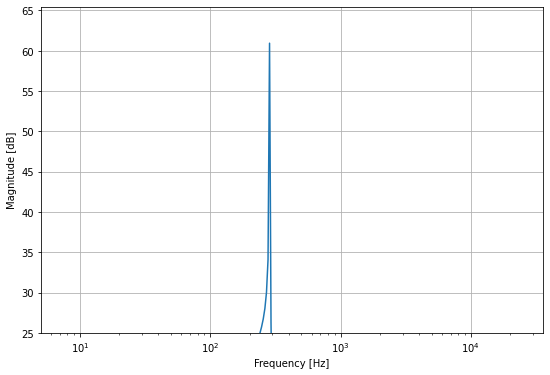

In [71]:
def create_sine_surge():
    surge = surgepy.createSurge(44100)
    patch = surge.getPatch()

    osc_type = patch['scene'][0]['osc'][0]['type'] # get oscillator type param handle
    surge.setParamVal(osc_type, srco.ot_sine) # set oscillator type to 'sine'
    surge.process()

    return surge, patch

def play_sine(surge):
    audio = surge.createMultiBlock(200)
    surge.playNote(0, 60, 127, 0)
    surge.processMultiBlock(audio)

    fft = 20*np.log10(np.fft.rfft(audio[0]))
    fftfreqs = np.fft.rfftfreq(len(audio[0]), 1.0 / 48000)

    plt.semilogx(fftfreqs, fft)
    plt.ylim(25)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid()

# play example audio
surge, patch = create_sine_surge()
play_sine(surge)

As we can see, there's only a single harmonic in the output signal from the generated sine tone. Let's see if we can generate more harmonics by activating the distortion effect!

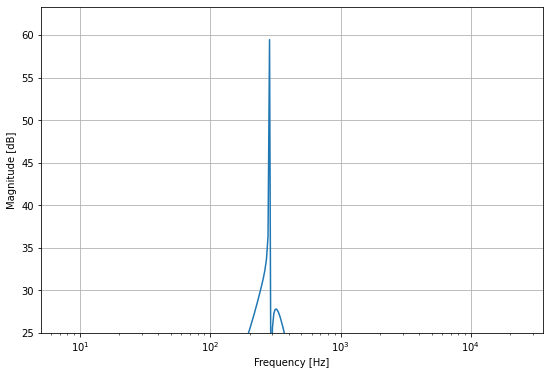

In [72]:
def activate_distortion(surge, patch):
    fx_slot = patch['fx'][srco.fxslot_global1]['type']
    surge.setParamVal(fx_slot, srco.fxt_distortion)
    surge.process()

surge, patch = create_sine_surge()
activate_distortion(surge, patch)
play_sine(surge)

## Setting Effect Parameters

Unfortunately, it doesn't look like our processed audio has any new harmonics. For the distortion effect, we also need to be able to change the parameter values in order to create harmonic distortion. From the user manual, we know that the fourth parameter should change the "Drive" parameter. Let's take a look at the range for this parameter.

In [73]:
drive_param = patch['fx'][srco.fxslot_global1]['p'][4]
print(surge.getParamInfo(drive_param))

Parameter name: FX M1 Param 5
Parameter value: 0
Parameter min: -24
Parameter max: 24
Parameter default: 0
Parameter value type: float
Parameter display value: 0.00 dB



While we're at it, let's examine the "Waveshaper" and "Feedback" parameters:

In [74]:
feedback_param = patch['fx'][srco.fxslot_global1]['p'][5]
waveshaper_param = patch['fx'][srco.fxslot_global1]['p'][11]

print('Feedback:')
print(surge.getParamInfo(feedback_param))

print('Waveshaper:')
print(surge.getParamInfo(waveshaper_param))

Feedback:
Parameter name: FX M1 Param 6
Parameter value: 0
Parameter min: -1
Parameter max: 1
Parameter default: 0
Parameter value type: float
Parameter display value: 0.00 %

Waveshaper:
Parameter name: FX M1 Param 12
Parameter value: 0
Parameter min: 0
Parameter max: 4
Parameter default: 0
Parameter value type: int
Parameter display value: Soft



Now, we're ready to tune these parameters to whatever values we like before processing the audio!

Drive: 24.00 dB
Feedback: 0.00 %
Waveshaper: Asymmetric


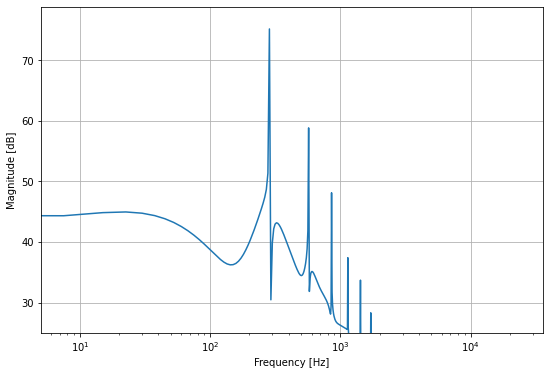

In [78]:
surge, patch = create_sine_surge()
activate_distortion(surge, patch)

drive_param = patch['fx'][srco.fxslot_global1]['p'][4]
feedback_param = patch['fx'][srco.fxslot_global1]['p'][5]
waveshaper_param = patch['fx'][srco.fxslot_global1]['p'][11]

surge.setParamVal(drive_param, 24.0)
surge.setParamVal(feedback_param, 0)
surge.setParamVal(waveshaper_param, 2)
surge.process()

print(f'Drive: {surge.getParamDisplay(drive_param)}')
print(f'Feedback: {surge.getParamDisplay(feedback_param)}')
print(f'Waveshaper: {surge.getParamDisplay(waveshaper_param)}')

play_sine(surge)

There it is! We have now successfully used the Surge Python API to generate a sine tone with harmonic distortion.